# Drug Interaction and Enzyme Kinetics

In this workbook we will introduce *Python* commands for importing and manipulating data. then we will curve fit and plot using what we learned in the previous tutorial.

## IMPORTANT! Go to the end of this notebook and execute the final code block FIRST. 

The last block of code contains the definitions for the functions used in this document.



## Setting Up the Data

The code below will print out the data file that we are using as text. Examine it and decide your next steps.

Choose from one of the following data files and modify the code below to access it...

- Data-0.csv
- Data-1.csv
- Data-2.csv
- Data-3.csv
- Data-4.csv
- Data-5.csv
- Data-6.csv
- Data-7.csv
- Data-8.csv
- Data-9.csv


## Example Analysis

In the following example I will obtain the $V_{max}$ and $K_M$ values in the case of warfarin with cyp450 and again with the presence of a potential inhibitor.

First let us examine the raw text data file with our eyes...

In [5]:
########################
## Triclofenac B
########################

############################################
### Identify the data file and examine it
############################################

data_file = "Data-B.csv"       ### You will need to change this name

file_url = github_data_location + data_file   ### The data is on a web site so I add the web site to the file name here

page = requests.get(file_url)  ### pull in a file from the web (github in this case)
print(page.text)               ### print out the text contents of the web page file.


MissingSchema: Invalid URL './data/Data-B.csv': No scheme supplied. Perhaps you meant https://./data/Data-B.csv?

## Load the Data

We see that the data is organized in a format.  There are comments describing conditions and information about the format. This will enable you to interpret the data. There are also lines of data organized in columns. 

We will import this text fime into a data structure called a 'dataframe'. This is the *Python* version of a spreadsheet. The dataframe has tools built into it for manipulating the data. If you examine the code at the very end of the spreadsheet you will see examples of this.

Below we us the Pandas package (loaded in as 'pd') and the Pandas.read_csv() function to parse the data file and create the dataframe object. The dataframe is then printed out for your inspection.

Note that I manually entered some data that was in the comments, such as the concentration of the potential inhibitor and the enzyme concentration. You can use this data later to calculate the dissociation conatnat for inhibition, $K_i$.

In [6]:
#######################
## Facts from data file comments
#######################

conc_enzyme = 1 ## nanomole/L 
conc_inh = 2    ## millimole/L
name_inh = "triclofenac B"
name_substrate = "warfarin"

################################################################################
### Read data set. The fields are separated by commas; comments are ignored 
################################################################################

data = pd.read_csv(file_url, 
                 delimiter = ",", 
                 skipinitialspace = True,
                 header = None, 
                 index_col = None, 
                 comment = "#") 
display(data)


,0,1,2,3,4,5,6
0,[warfarin] (uM),2.8,4.6,6.4,9.1,17.9,26.9
1,time (min),[product /nM],[product /nM],[product /nM],[product /nM],[product /nM],[product /nM]
2,1.0,5.2,8.9,11.1,13.2,15.9,20.4
3,2.0,10.8,17.9,21.1,23.9,32.4,40.3
4,3.0,16.0,24.9,31.7,38.8,53.3,55.4
5,4.0,24.3,35.5,39.1,48.2,61.1,70.8
6,5.0,26.2,40.4,46.6,58.1,76.7,88.8
7,7.0,41.6,58.7,68.0,86.4,107.5,133.3
8,8.0,42.5,66.6,78.8,102.3,125.8,149.3
9,[warfarin] (uM),1.0,1.9,4.6,6.4,10.0,13.6


## Edit the DataFrame

The dataframe has two sets of data in it.  the code below will separate the two chuncks of data and create two new dataframes. You will need to change the numbers in the slices if your data has a different number of lines that the set presented here.

The final dataframes are a seris of columns. there is a column for the time of measurements and columns for the amount of product formed at each time point. Each column is the result of an experiment with a different concentration of the substrate and these concentration values are listed at the top of each column. In a Pandas dataframe the 'header' is the title of each column. I can access each column using the header value. You can see examples of this in the code at the end of this notebook.

In [21]:
################################################################################
### Separate the two groups of data and set up the dataframe for convenient access 
################################################################################

df = data.copy()           ### copy the dataframe to a generic name so I can easily reuse the code below
df = df[0:9]               ### slice rows 0 to 8 into a new dataframe

df_no_inh = trim_and_format_data(df)  ### will strip away unwanted rows and columns and set up column headers and index column


df = data.copy()           ### copy the dataframe again
df = df[9:]                ### slice rows 9 to the end into a new dataframe

df_inh = trim_and_format_data(df)     ### will strip away unwanted rows and columns and set up column headers and index column

################################################################################
### We now have dataframes with the data in rows labeled by the time points
### and each column labelled by the substrate concentration
################################################################################

print("Data for warfarin only no inhibitor")
#display(df_no_inh)

print("Data for warfarin with drup -- potential inhibitor")
#display(df_inh)


Data for warfarin only no inhibitor
Data for warfarin with drup -- potential inhibitor


### Calculate Rates at Each Concentration

The experiment will enable us to calculate the reaction rate at a given concentration by taking the slope of the plot of concentration vs. time for the appearance of product. The function 'get_slopes_and_plot_them_all' will take a dataframe, curve fit each column agains time to get the slopes, plot all data and slopes, and finaly return the list of slopes and a list of the concentrations of the substrate.

You now have a set of rates and a set of concentrations.

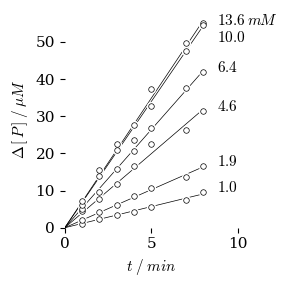

Float64Index([1.0, 1.9, 4.6, 6.4, 10.0, 13.6], dtype='float64', name=0)


array([1.13750000011209+/-0.02322572973541782,
       2.0494047619070512+/-0.02709368795428241,
       3.986309523816037+/-0.1040762077699688,
       5.283333333342676+/-0.041347987458851466,
       6.7946428571554955+/-0.1416497839159549,
       6.9732142857273125+/-0.12141471133516822], dtype=object)

In [22]:
################################################################################
### Take a dataframe of product concentrations vs time at different substrate
### concentrations and get slopes of each experiment and plot them all
### on a single graph
################################################################################

concs, rates = get_slopes_and_plot_them_all(df_inh,
                                            title = "", 
                                            xaxis = "$t\; /\; min$", 
                                            yaxis = "$\Delta\, [\,P\,]\; /\; \mu M$")

print(concs)
display(rates)

## Michaelis-Menten Plot

We will use a slightly modified vesrion of the MM_Plot() function from the previous tutorial.  This one has added error bars to the plot and uses the errors in the line fit (points with large errors are weighted less in the curve_fit algorithm).






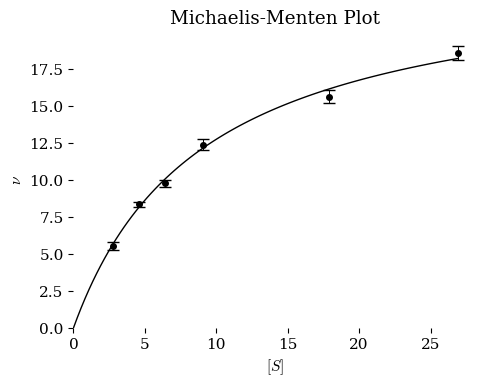

Vmax = 24.41+/-0.42
Km = 9.12+/-0.30


In [105]:
x = concs 
y = rates

Vmax, KM = MM_Plot(x, y)

print(f"Vmax = {Vmax:0.2f}\nKm = {KM:0.2f}")

## Lineweaver-Burke

We all hate it, but it is the one form of linearization that your textbook discusses so we will present it here. The Linear_Plot function from the previous tutorial has been modified to use errors as well. We will get the slope and intercept and calculate $V_{max}$ and $K_M$.

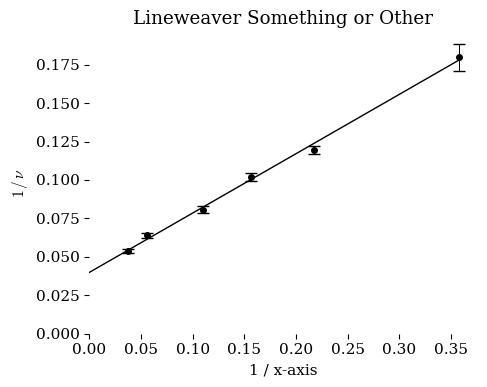

Slope = 0.39+/-0.01
Intercept = 0.040+/-0.002

Vmax = 25.11+/-1.37
Km = 9.70+/-0.60


In [106]:
x = 1 / concs 
y = 1 / rates    

slope, intercept = Linear_Plot(x, y,
                               title ="Lineweaver Something or Other", 
                               xaxis = "1 / x-axis", 
                               yaxis = "$1\\, /\\, \\nu$")

print(f"Slope = {slope:0.2f}\nIntercept = {intercept:0.3f}\n")  ### An exampe of the '\n' to make a new line

Vmax = 1 / intercept
KM = slope * Vmax

print(f"Vmax = {Vmax:0.2f}\nKm = {KM:0.2f}")

## You are Half Done

Now record the values you have calculated and download any plots you wish to present in your report. Then repeat the above with the other dataframe for the inhibited experiment. You will now have all the data that you need to finish the assignment.

## RUN THIS FIRST

Execute the final bock in this notebook below to establish all the functions and tools required in the code above.

In [20]:
############################################
###  Import packages and set up variables
############################################

from os import system                    ## import tools to access the file sytsem directly
from scipy.optimize import curve_fit
import numpy as np                       ## import the tools of NumPy but use a shorter name
import pandas as pd                      ## import tools for data handling
from matplotlib import pyplot as plt
import requests                          ## tools to access web content

## fancy plot style sheet
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
plt.style.use(github_location_styles + "tufte.mplstyle")        

github_data_location= "https://raw.githubusercontent.com/blinkletter/3530Biochem/main/T04/data/"
github_data_location= "./data/"

####################################
### Install UNCERTAINTIES package 
####################################

#!pip install uncertainties  # to install in Colab. Add it back to avoid installing again and again.

####################################
### Import versions of NumPy and Math that use uncertainty 
####################################

import uncertainties as un
from uncertainties import unumpy as unp
from uncertainties import umath as um


########################################################################
def trim_and_format_data(df):
    
    df.reset_index(inplace = True)             ### had to reset the index to give a first line with index '0'
    #display(df)                               ### uncomment to check whats happening to the dataframe
    df.drop(["index"], axis=1, inplace=True)   ### drop the former index column that was created by the reset 
    #display(df)
    
    df[0][0] = "Time (min)"                    ### Put the word 'Time" in the top corner - you'll see whey soon
    df.drop([1], inplace=True)                 ### drop the second row that is all text labels
    #display(df)
    
    ################################################################################
    ### We now have a dataframe with the data in rows labeled as 2 through 8.
    ### Row 0 is the concentrations of substrate. Let us uses these to index the dataframe
    ################################################################################
    
    df.columns = df.iloc[0]         ### Set the contents of the first row to be the column headers
    #display(df)
    
    df.drop([0], inplace=True)      ### drop the first row that is now set as the column headers

    df.reset_index(inplace = True)             ### again, had to reset the index to give a first line with index '0'
    #display(df)                               ### uncomment to check whats happening to the dataframe
    df.drop(["index"], axis=1, inplace=True)   ### drop the former index column that was created by the reset 
    
    return(df.copy())    ### copy the resulting editted dataframe to a more useful name

def get_slopes_and_plot_them_all(df, title ="Enter Title Here", xaxis = "x-axis", yaxis = "y-axis"):
    
    def linear_zero(x, slope):  ### Take x values, slope and intercept and return the y values
        y = slope * x
        return(y)
        
    #plt.rcdefaults()           ### Reset default style - not needed, but just in case.
    plt.figure(figsize=(3,3))  ### Establish a figure with size 5x4
    
    x = df.pop("Time (min)")   ### Pop (remove) the 'time' column and assign it to x
    x = x.astype('float')      ### For some reason all data was text. x now converted to floating point.
    
    list_slopes = []                ### create an empty list for slopes at each concentration

    for i in df.columns:            ### Get each column name one-at-a-time in turn

        y = df[i].astype('float')                   ### Get each column of concentrations and convert to floating point
        slope, cov = curve_fit(linear_zero, x, y)   ### two objects are returned

        x_fit = np.linspace(0, np.max(x), 50)       ### Make line for curve fit
        
        perr = np.sqrt(np.diag(cov))            ### convert covariance matrix to stdev values
        stdev_slope = perr                      ### pull out the two stdev values 
        slope_u = un.ufloat(slope,stdev_slope)  ### create a value with uncertainty built in
        list_slopes.append(slope_u)             ### add slope value to the list

        plt.plot(x_fit, linear_zero(x_fit, slope),
                "k-", linewidth = 0.5, zorder = 0)   ### Plot the line   

        plt.scatter(x, y, marker = "o",
                    c = "white", s = 32)                                ### Plot each column against time


        if i == "26.9":
            i = i+"\; m\!M"
        if i == "13.6":
            i = i+"\; m\!M"

        y_text_loc = np.max(y)
        if i == "10.0":
            y_text_loc = y_text_loc - 5


        plt.text(np.max(x) + 0.8, y_text_loc, "$"+i+"$")          ### label each line on the plot
    
    for i in df.columns:            ### Get each column name one-at-a-time in turn
        y = df[i].astype('float')                   ### Get each column of concentrations and convert to floating point
        plt.scatter(x, y, marker="o", 
                    c = "white", s = 16,
                    edgecolors = "black", 
                    linewidths=0.5)            


    
    plt.ylim(0, None)
    plt.xlim(0, 10)
    plt.ylabel(yaxis)
    plt.xlabel(xaxis)
    plt.title(title)

    plt.savefig("MultiPlot.pdf")
    plt.show()

    concs = df.columns.astype('float')                ### Convert list of conc from column header to array of floating point
    list_slopes_n = unp.nominal_values(list_slopes)   ### Rates is a list of uncertainty values
    list_slopes_s = unp.std_devs(list_slopes)         ### separate them into lists of nominal values and std deviations                           
    rates = unp.uarray(list_slopes_n, list_slopes_s)  ### create an array of uncertainty values using Uncertainties.uNumPy.uarray()

    return(concs, rates)

def MM_Plot(x, y):

    ####################################
    ### Define the MM equation for the curve fit as a function
    ####################################

    def MMplot(S, Vmax, KM):
        v = Vmax * S / (S + KM)
        return(v)
        
    ####################################
    ### Perform the curve fit
    ####################################
    
    y_stdev = unp.std_devs(y)   ### y is a set of uncertainty values. Extract the two parts
    y       = unp.nominal_values(y)

    params, stats = curve_fit(MMplot, x, y,          ## two objects are returned
                              sigma = y_stdev,       ## include stdevs in curve fit
                              absolute_sigma = True) ## errors are values, not relative.
    
    ####################################
    ### Interpret the results
    ####################################
    
    v_max, KM = params   ### pull out the two values in the params object
    
    perr = np.sqrt(np.diag(stats))          ### convert covariance matrix to stdev values
    stdev_v_max, stdev_KM = perr            ### pull out the two stdev values 
    
    v_max_u = un.ufloat(v_max,stdev_v_max)  ### create a value with uncertainty built in
    KM_u = un.ufloat(KM,stdev_KM)
    
    ################################
    ### make a list of x values from zero to the end of the line
    ################################
    
    x_fit = np.linspace(0, np.max(x), 100) 
    
    ################################
    ### Feed that list into the function for the line fit
    ################################
    
    y_fit = MMplot(x_fit,v_max,KM)
    
    ######################
    ### Create an empty plot
    #####################
    
    #plt.rcdefaults()           
    plt.figure(figsize=(5,4))  
    
    ######################
    ### Plot the data and the curve fit line
    #####################
    
    plt.plot(x, y, "ko", markersize = 4)

    plt.errorbar(x, y, yerr = 2*y_stdev,
                 fmt="none", color = "black",
                 elinewidth =0.7, capsize = 4)

    plt.plot(x_fit, y_fit, "k-", linewidth = 1)   
                                                                                                     
    ######################
    ### Add some style
    #####################
    
    plt.ylim(0, None)
    plt.xlim(0, None)
    
    plt.ylabel(r"$\nu$")  
    plt.xlabel(r"$[S]$")
    plt.title("Michaelis-Menten Plot")
    
    ######################
    ### Display and export the plot
    ######################
    
    plt.savefig("MM_plot.pdf")
    plt.show()

    return v_max_u, KM_u

def Linear_Plot(x, y, title ="Enter Title Here", xaxis = "x-axis", yaxis = "y-axis"):

    def linear(x, slope, intercept):  ### Take x values, slope and intercept and return the y values
        y = slope * x + intercept
        return(y)



    y_stdev = unp.std_devs(y)   ### y is a set of uncertainty values. Extract the two parts
    y       = unp.nominal_values(y)

    params, stats = curve_fit(linear, x, y,          ## two objects are returned
                              sigma = y_stdev,       ## include stdevs in curve fit
                              absolute_sigma = True) ## errors are values, not relative.
    
 



    params, stats = curve_fit(linear, x, y)   ## two objects are returned
    
    ####################################
    ### Interpret the results
    ####################################
    
    slope, intercept = params   ### pull out the two values in the params object
    
    perr = np.sqrt(np.diag(stats))        ### convert covariance matrix to stdev values
    stdev_slope, stdev_intercept = perr   ### pull out the two stdev values 
    
    slope_u = un.ufloat(slope,stdev_slope)               ## create a value with uncertainty built in
    intercept_u = un.ufloat(intercept,stdev_intercept)  
    
        
    ################################
    ### make a list of x values from zero to the end of the line
    ################################
    
    x_fit = np.linspace(0, np.max(x), 100)  ## 100 points from 0 to the highest value on LB plot x-axis
    
    ################################
    ### Feed that list into the function for the line fit
    ################################
    
    y_fit = linear(x_fit, slope, intercept)
    
    ######################
    ### Create an empty plot
    #####################
    
    #plt.rcdefaults()           
    plt.figure(figsize=(5,4))  
    
    ######################
    ### Plot the data and the curve fit line
    #####################
    
    plt.plot(x, y, "ko", markersize = 4)

    plt.errorbar(x, y, yerr = 2*y_stdev,
             fmt="none", color = "black",
             elinewidth =0.7, capsize = 4)

    plt.plot(x_fit, y_fit, "k-", linewidth = 1)   

    ######################
    ### Add some style
    #####################
    
    plt.ylim(0, None)
    plt.xlim(0, None)
    
    plt.ylabel(yaxis)
    plt.xlabel(xaxis)
    plt.title(title)
    
    ######################
    ### Display and export the plot
    #####################
    
    plt.savefig("Linear_plot.pdf")
    plt.show()

    return slope_u, intercept_u



In [27]:
data = pd.read_csv("X_Uninh_result.csv", 
                 delimiter = ",", 
                 skipinitialspace = True,
#                 header = None, 
                 index_col = None, 
                 comment = "#") 
display(data)
df1 = data.copy()

data = pd.read_csv("X_Inh_result.csv", 
                 delimiter = ",", 
                 skipinitialspace = True,
#                 header = None, 
                 index_col = None, 
                 comment = "#") 
display(data)
df2 = data.copy()

,Conc. mM,slope,slope_err
0,2.8,5.560714,0.135842
1,4.6,8.375595,0.089031
2,6.4,9.786905,0.123969
3,9.1,12.404167,0.175218
4,17.9,15.639286,0.224472
5,26.9,18.582738,0.230209


,Conc. mM,slope,slope_err
0,1.0,1.137500,0.023226
1,1.9,2.049405,0.027094
2,4.6,3.986310,0.104076
3,6.4,15.283333,0.041348
4,10.0,16.794643,0.141650
5,13.6,16.973214,0.121415


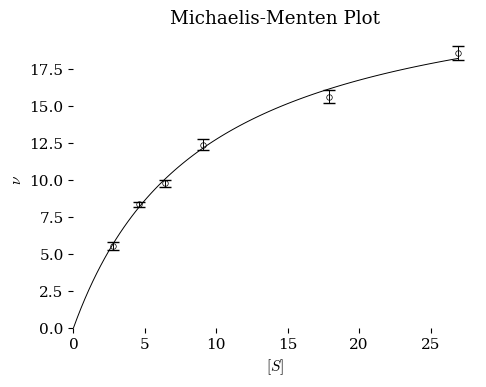

In [31]:
x = df1["Conc. mM"]
y = df1["slope"]
y_stdev = df1["slope_err"]

####################################
### Define the MM equation for the curve fit as a function
####################################
def MMplot(S, Vmax, KM):
    v = Vmax * S / (S + KM)
    return(v)
    
####################################
### Perform the curve fit
####################################

params, stats = curve_fit(MMplot, x, y,          ## two objects are returned
                          sigma = y_stdev,       ## include stdevs in curve fit
                          absolute_sigma = True) ## errors are values, not relative.

####################################
### Interpret the results
####################################

v_max, KM = params   ### pull out the two values in the params object

perr = np.sqrt(np.diag(stats))          ### convert covariance matrix to stdev values
stdev_v_max, stdev_KM = perr            ### pull out the two stdev values 

v_max_u = un.ufloat(v_max,stdev_v_max)  ### create a value with uncertainty built in
KM_u = un.ufloat(KM,stdev_KM)

################################
### make a list of x values from zero to the end of the line
################################

x_fit = np.linspace(0, np.max(x), 100) 

################################
### Feed that list into the function for the line fit
################################

y_fit = MMplot(x_fit,v_max,KM)

######################
### Create an empty plot
#####################

#plt.rcdefaults()           
plt.figure(figsize=(5,4))  

######################
### Plot the data and the curve fit line
#####################

plt.plot(x_fit, y_fit, "k-", linewidth = 0.7)   


plt.scatter(x, y, marker="o", 
            c = "white", s = 32)            

plt.errorbar(x, y, yerr = 2*y_stdev,
             fmt="none", color = "black",
             elinewidth =0.7, capsize = 4)

plt.scatter(x, y, marker="o", 
            c = "white", s = 16,
            edgecolors = "black", 
            linewidths=0.5)            

                                                                                                 
######################
### Add some style
#####################

plt.ylim(0, None)
plt.xlim(0, None)

plt.ylabel(r"$\nu$")  
plt.xlabel(r"$[S]$")
plt.title("Michaelis-Menten Plot")

######################
### Display and export the plot
######################

plt.savefig("MM_plot.pdf")
plt.show()